In [172]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max


In [194]:
def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def pimg(img, label=""):
    print(label, end="")
    plt.imshow(img)
    plt.show()

def highlight_labels(img, labels, value=255):
    image = img.copy()
    
    for label in labels:
        np.putmask(image, image == label, np.full(image.shape, value).astype('uint16'))
        image = image.astype('uint16')
        np.putmask(image, image != label, np.zeros(image.shape).astype('uint16'))
                
    return image

def masks_to_binary(img):
    image = img.copy()
    
    np.putmask(image, image != 0, np.ones(image.shape).astype('uint16'))
    image = image.astype('uint16')
    np.putmask(image, image == 0, np.zeros(image.shape).astype('uint16'))
    
    return image

def equalize_clahe(img):
    image = img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded

def get_min_dist_marker(cell_mask, x, y, label):
    image = cell_mask.copy()
    
    min_dist = 9999999999
    
    #coords is list of coordinates of pixels that have their values as param:label
    coords = np.argwhere(image == label)
    
    dists = np.sqrt((coords[:,0] - x) ** 2 + (coords[:,1] - y) ** 2)
    
    min_dist_index = np.argmin(dists)
                   
    return (dists[min_dist_index])

def get_max_dt_sq(img, label):
# from equation (1) in https://is.muni.cz/www/svoboda/ISBI-final.pdf
    #constants
    A = 0.004
    B = 40
        
    image = img.copy()
    image = image.astype('uint16')

    high_mask = highlight_labels(image, [ label ], value=label)

    inv = np.logical_not(high_mask)
    inv = inv.astype('uint8')

    dt = cv2.distanceTransform(inv, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)

    max_dt_sq = (np.maximum( B-dt , 0 ))**2
    
    return max_dt_sq

In [195]:
def get_origs(path="test_dir/orig"):  #"DIC-2/02"):
    origs = []
    
    for filename in fi_list(path):
        if not filename.endswith(".tif"):
            continue
        
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        origs.append(image)
        
    return np.array(origs)

def get_clahes(origs):
    clahes = []
    
    for orig in origs:
        clahed = equalize_clahe(orig)
        clahes.append(clahed)
    
    return np.array(clahes)

def get_cell_masks(path="test_dir/st"):    #"DIC-2/02_ST/SEG"):
    cell_masks = []
    
    #debug
    count = 0
    for filename in fi_list(path):
        if not filename.endswith(".tif"):
            continue
        
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        cell_masks.append(image)
        
        #debug
        count+=1
        if count > 5:
            break
        
    return np.array(cell_masks)

def get_binary_cell_masks(cell_masks):
    bin_cell_masks = []
    
    for cell_mask in cell_masks:
        bin_c_m = masks_to_binary(cell_mask)
        bin_cell_masks.append(bin_c_m)
    
    return np.array(bin_cell_masks)

# requires NON_BINARY cell masks
def get_cell_markers(cell_masks, erosion_radius=24):    
    cell_markers = []
    
    for mask in cell_masks:
        # array of individual images binarized by label and eroded
        eroded = np.zeros(mask.shape)
        
        labels = list(np.unique(mask))
        
        #drop background
        labels.remove(0)
        
        for label in labels:
            # extract each labeled cell mask separately
            high_mask = highlight_labels(mask, [label], value=label)
            
            #erode it with a disk structuring element
            temp_erod = disk_erode(high_mask, erosion_radius)
            
            #add this label mask to the final combined mask
            eroded = np.add(eroded, temp_erod)
            
        cell_markers.append(eroded)
        
    return np.array(cell_markers)

# requires NON_BINARY cell masks
def get_binary_cell_markers(cell_masks, erosion_radius=24):
    cell_markers = []
    
    for mask in cell_masks:
        # array of individual images binarized by label and eroded
        eroded = np.zeros(mask.shape)
        
        labels = list(np.unique(mask))
        
        #drop background
        labels.remove(0)
        
        for label in labels:
            # extract each labeled cell mask separately
            high_mask = highlight_labels(mask, [label], value=label)
            
            #erode it with a disk structuring element
            temp_erod = disk_erode(high_mask, erosion_radius)
            
            #add this label mask to the final combined mask
            eroded = np.add(eroded, temp_erod)
            
        cell_markers.append(masks_to_binary(eroded))
        
    return np.array(cell_markers)

#TODO: algorithm is implemented but not tested. Currently takes too long to run for even one picture
#      Optimize 
def get_weight_maps(cell_markers, subtract_marker_flag=False):
    #constants
    A = 0.004
    B = 40

    weight_maps = []
    
    for cell_marker in cell_markers:
        #debug
        count = 0
        
        labels = list(np.unique(cell_marker))
        labels.remove(0)
        
        max_dt_sq = np.zeros(cell_marker.shape)
        
        for label in labels:
            max_dt_sq = np.add(max_dt_sq, get_max_dt_sq(cell_marker, label))
        
        pix_weight = 1 + (A * max_dt_sq)
        
        # try with flag = True if default doesn't work. The equation probably doesnt need the following
        # but the sample image in paper https://is.muni.cz/www/svoboda/ISBI-final.pdf seems to show
        # subtracted markers.
        if subtract_marker_flag == True:
            inv_bin_cell_marker = np.logical_not(masks_to_binary(cell_marker)).astype('uint16')
            pix_weight = np.multiply(pix_weight, inv_bin_cell_marker)
        
        weight_maps.append(pix_weight)
        
    return np.array(weight_maps)


In [196]:
def get_pred_masks():
    return get_binary_cell_masks(get_cell_masks())

def get_pred_markers(pred_masks, e_r):
    return get_binary_cell_markers(get_cell_masks(), e_r)

In [233]:
def threshold_binary_image(img, thresh=0.5):
    image = img.copy()
    
    print(np.unique(image*1.0 >= thresh))
    
#     np.putmask(image, image*1.0 >= thresh, np.ones(image.shape).astype('uint8'))
#     image = image.astype('uint8')
#     np.putmask(image, image*1.0 < thresh, np.zeros(image.shape).astype('uint8'))
    
    return (image*1.0 >= thresh).astype('uint8')

[False  True]
[False]


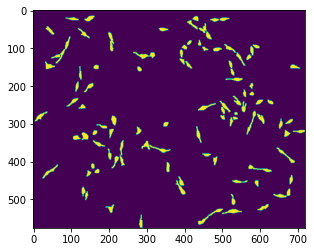

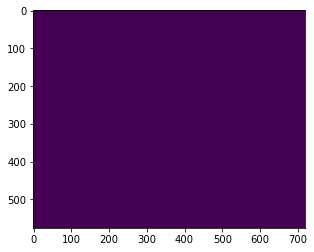

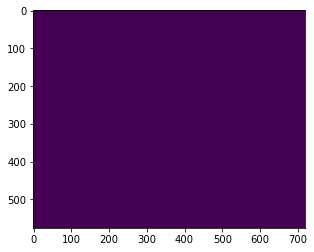

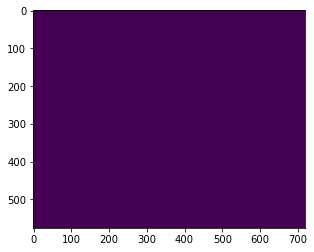

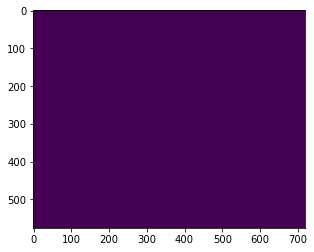

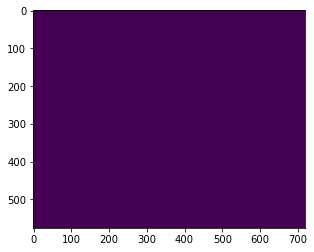

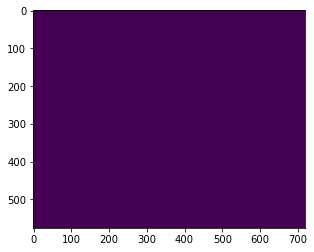

In [235]:
ELEMENT_NO = 2
# 0 -> Fluo, 1-> DIC, 2 -> PhC

# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)



pred_masks = get_pred_masks()
pred_markers = get_pred_markers(pred_masks, 24)

#constants
OPEN_RADIUS = 1
# = 12 for 1, =

# mask_thresh = cv2.threshold(pred_masks[ELEMENT_NO], 129, 255, cv2.THRESH_BINARY)[1]
mask_thresh = threshold_binary_image(pred_masks[ELEMENT_NO], 0.5)
# marker_thresh_unopen = cv2.threshold(pred_markers[ELEMENT_NO], 129, 255, cv2.THRESH_BINARY)[1]
marker_thresh_unopen = threshold_binary_image(pred_markers[ELEMENT_NO], 0.5)

# marker_thresh = cv2.morphologyEx(marker_thresh_unopen, cv2.MORPH_OPEN, disk(OPEN_RADIUS))
marker_thresh = marker_thresh_unopen

distance = ndi.distance_transform_edt(marker_thresh)

# local_maxi = peak_local_max(pred_markers, indices=False, footprint=np.ones((10, 10)),
#                         labels=thresh)
# markers, _ = ndi.label(local_maxi)
markers, _ = ndi.label(marker_thresh)

ws_labels = watershed(-distance, markers, mask=mask_thresh)


# a = pred_masks[ELEMENT_NO]
# b = pred_markers[ELEMENT_NO]
a = mask_thresh
b = marker_thresh_unopen
c = marker_thresh
d = distance
e = markers
f = ws_labels

h = pred_markers[ELEMENT_NO]
pimg(a)
pimg(b)
pimg(c)
pimg(d)
pimg(e)
pimg(f)

pimg(h)

In [178]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[1]
# b = get_clahes(origs)[1]
# c = cell_masks[1]
# d = cell_markers[1]

# h = weight_maps[1]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

In [179]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 8)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[0]
# b = get_clahes(origs)[0]
# c = cell_masks[0]
# d = cell_markers[0]

# h = weight_maps[0]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

In [180]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 2)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[2]
# b = get_clahes(origs)[2]
# c = cell_masks[2]
# d = cell_markers[2]

# h = weight_maps[2]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)